In [1]:
# Cell 1: Import Libraries

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Cell 2: Check for CUDA (GPU)

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Using device: {torch.device('cuda')}")
else:
    print("CUDA is not available. The model will run on the CPU.")

CUDA is available!
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [3]:
# Cell 3: Load the Dataset

# Load the dataset
file_name = r"C:\Users\rugwe\OneDrive\Desktop\Value_momentum\synthetic_insurance_renewal_data.csv"
df = pd.read_csv(file_name)

# Display basic information
print(df.info())

# Set pandas to display all columns
pd.set_option('display.max_columns', None)
print("\nFirst 5 rows of the dataset:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Policy_ID                50000 non-null  object 
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Region                   50000 non-null  object 
 4   Policy_Type              50000 non-null  object 
 5   Policy_Tenure_Years      50000 non-null  int64  
 6   Number_of_Claims         50000 non-null  int64  
 7   Total_Claim_Amount       50000 non-null  float64
 8   Last_Claim_Date          14089 non-null  object 
 9   Avg_Time_Between_Claims  50000 non-null  float64
 10  Annual_Premium           50000 non-null  float64
 11  Payment_Frequency        50000 non-null  object 
 12  On_Time_Payments         50000 non-null  int64  
 13  Missed_Payments          50000 non-null  int64  
 14  Total_Paid            

In [4]:
# Cell 4: Feature Engineering (Part 1 - Dates)

# Convert date columns to datetime objects
date_cols = ['Last_Claim_Date', 'Last_Payment_Date', 'Last_Contact_Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# We need a reference date to calculate "days since". 
# We'll use the most recent date in the entire dataset as our "snapshot date".
snapshot_date = df[date_cols].max().max()
print(f"\nSnapshot date (simulating 'today'): {snapshot_date.date()}")

# Calculate 'days since' features
df['Days_Since_Last_Payment'] = (snapshot_date - df['Last_Payment_Date']).dt.days
df['Days_Since_Last_Contact'] = (snapshot_date - df['Last_Contact_Date']).dt.days
df['Days_Since_Last_Claim'] = (snapshot_date - df['Last_Claim_Date']).dt.days

# Handle missing values from date calculations:
# If 'Days_Since_Last_Claim' is NaN, it means they never made a claim. 
# We'll fill this with a large number (e.g., tenure in days + a buffer)
# to signify a very long time.
df['Days_Since_Last_Claim'] = df['Days_Since_Last_Claim'].fillna(df['Policy_Tenure_Years'] * 365 + 365)

print("Created 'Days_Since' features.")


Snapshot date (simulating 'today'): 2025-10-15
Created 'Days_Since' features.


In [5]:
# Cell 5: Feature Engineering (Part 2 - Ratios & Imputation)

# Fill NaNs in 'Avg_Time_Between_Claims' (likely for 0 or 1 claim). We'll fill with 0.
df['Avg_Time_Between_Claims'] = df['Avg_Time_Between_Claims'].fillna(0)

# Create Payment_Ratio (On-Time / Total)
# Use np.where to avoid division by zero
total_payments = df['On_Time_Payments'] + df['Missed_Payments']
df['Payment_Ratio'] = np.where(total_payments > 0, df['On_Time_Payments'] / total_payments, 0)

# Create Claim_Rate (Claims / Tenure)
# Use np.where to avoid division by zero
df['Claim_Rate'] = np.where(df['Policy_Tenure_Years'] > 0, df['Number_of_Claims'] / df['Policy_Tenure_Years'], 0)

print("Created 'Payment_Ratio' and 'Claim_Rate' features.")
print("\nDataFrame head with new features:")
print(df[['Policy_Tenure_Years', 'Days_Since_Last_Claim', 'Payment_Ratio', 'Claim_Rate']].head())

Created 'Payment_Ratio' and 'Claim_Rate' features.

DataFrame head with new features:
   Policy_Tenure_Years  Days_Since_Last_Claim  Payment_Ratio  Claim_Rate
0                    9                 3650.0       0.857143         0.0
1                    1                  876.0       0.979592         1.0
2                    8                 3285.0       0.958333         0.0
3                    5                 2190.0       0.968750         0.0
4                    0                  365.0       1.000000         0.0


In [6]:
# Cell 6: Define Features (X) and Target (y)

# Define the target variable
y = df['Renewed']

# Define the features (X)
# We drop the target variable 'Renewed' and the original columns
# that we engineered or are identifiers (like Policy_ID).
X = df.drop(columns=[
    'Policy_ID', 
    'Renewed', 
    'Last_Claim_Date', 
    'Last_Payment_Date', 
    'Last_Contact_Date'
])

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")

Feature matrix (X) shape: (50000, 24)
Target vector (y) shape: (50000,)


In [7]:
# Cell 7: Split Data into Training and Testing Sets

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% of data for testing
    random_state=42,  # Ensures reproducible results
    stratify=y        # Ensures balanced classes in both splits
)

print(f"Training set shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shapes: X={X_test.shape}, y={y_test.shape}")

Training set shapes: X=(40000, 24), y=(40000,)
Testing set shapes: X=(10000, 24), y=(10000,)


In [8]:
# Cell 8: Create Preprocessing Pipeline

# Identify categorical and numerical features automatically
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

# Create a transformer for numeric features
# We will scale them to have a standard distribution
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
# We will one-hot encode them
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the master preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any columns we missed (though we shouldn't have)
)

print("\nPreprocessing pipeline created successfully.")


Numeric features (19): ['Age', 'Policy_Tenure_Years', 'Number_of_Claims', 'Total_Claim_Amount', 'Avg_Time_Between_Claims', 'Annual_Premium', 'On_Time_Payments', 'Missed_Payments', 'Total_Paid', 'Credit_Score', 'Support_Tickets', 'Satisfaction_Score', 'Customer_Lifetime_Value', 'Has_Previous_Accident', 'Days_Since_Last_Payment', 'Days_Since_Last_Contact', 'Days_Since_Last_Claim', 'Payment_Ratio', 'Claim_Rate']

Categorical features (5): ['Gender', 'Region', 'Policy_Type', 'Payment_Frequency', 'Interaction_Channel']

Preprocessing pipeline created successfully.


In [9]:
# Cell 9: Apply Preprocessing

# Fit the preprocessor on the training data and transform it
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data using the *same* fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

# Get the names of the new, processed features
feature_names = preprocessor.get_feature_names_out()

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")
print(f"\nExample of first 5 processed feature names:\n{feature_names[:5]}")

Processed training data shape: (40000, 38)
Processed testing data shape: (10000, 38)

Example of first 5 processed feature names:
['num__Age' 'num__Policy_Tenure_Years' 'num__Number_of_Claims'
 'num__Total_Claim_Amount' 'num__Avg_Time_Between_Claims']


In [10]:
# Cell 10: Import, Create, and Train the Model

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score
)
import matplotlib.pyplot as plt

# 1. Define the model
# We set max_iter=1000 to ensure the model converges with this data
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# 2. Create the full pipeline
# This bundles the preprocessing from Cell 8 with the model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

# 3. Train the model
# We fit the pipeline on the *original* training data (X_train, y_train)
# The pipeline handles all preprocessing internally.
print("Training the Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


In [11]:
# Cell 11: Evaluate Model Performance

# Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Get prediction probabilities (for ROC-AUC score)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# 1. Calculate key metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC-AUC Score: {roc_auc_lr:.4f}")

# 2. Print the detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Did Not Renew (0)', 'Renewed (1)']))

--- Logistic Regression Evaluation ---
Accuracy: 0.7655
ROC-AUC Score: 0.8061

Classification Report:
                   precision    recall  f1-score   support

Did Not Renew (0)       0.62      0.50      0.55      2895
      Renewed (1)       0.81      0.87      0.84      7105

         accuracy                           0.77     10000
        macro avg       0.71      0.69      0.70     10000
     weighted avg       0.75      0.77      0.76     10000



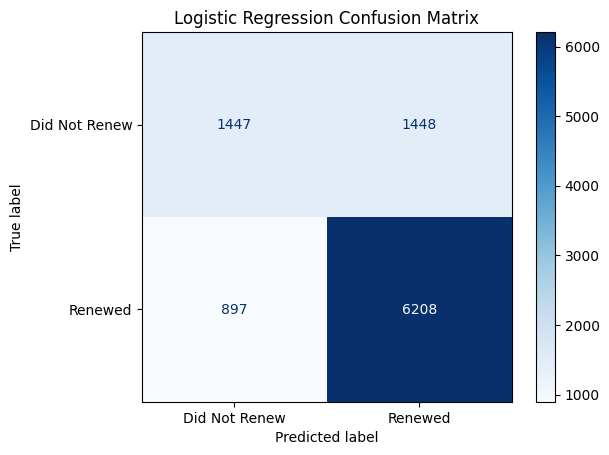

In [12]:
# Cell 12: Visualize the Confusion Matrix

# Generate the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr, 
    display_labels=['Did Not Renew', 'Renewed']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Logistic Regression Confusion Matrix')
plt.grid(False)
plt.show()

In [13]:
# Cell 13: Analyze Feature Importance (The "Why")
# This is the most powerful part of Logistic Regression. We can extract the "coefficients" the model learned.
# Positive coefficients mean the feature increases the probability of renewal.
# Negative coefficients mean the feature decreases the probability of renewal.

# Extract the fitted model and preprocessor from the pipeline
fitted_model = lr_pipeline.named_steps['model']
fitted_preprocessor = lr_pipeline.named_steps['preprocessor']

# Get the feature names from the preprocessor
feature_names = fitted_preprocessor.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = fitted_model.coef_[0]

# Create a DataFrame to store feature importances
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by coefficient value
coef_df = coef_df.sort_values('Coefficient', ascending=False)

# Display the most impactful features
print("--- Feature Importance (Logistic Regression) ---")
print("\nTop 10 features INCREASING renewal probability:")
print(coef_df.head(10).to_string())

print("\nTop 10 features DECREASING renewal probability (predicting non-renewal):")
print(coef_df.tail(10).sort_values('Coefficient', ascending=True).to_string())

--- Feature Importance (Logistic Regression) ---

Top 10 features INCREASING renewal probability:
                                       Feature  Coefficient
12                num__Customer_Lifetime_Value     1.618079
20                            cat__Gender_Male     0.222153
19                          cat__Gender_Female     0.205714
31               cat__Payment_Frequency_Annual     0.190111
32              cat__Payment_Frequency_Monthly     0.186715
33            cat__Payment_Frequency_Quarterly     0.185275
30  cat__Policy_Type_Third-Party, Fire & Theft     0.156367
36              cat__Interaction_Channel_Email     0.151452
35               cat__Interaction_Channel_Chat     0.147481
26                            cat__Region_West     0.146633

Top 10 features DECREASING renewal probability (predicting non-renewal):
                         Feature  Coefficient
13    num__Has_Previous_Accident    -0.063546
16    num__Days_Since_Last_Claim    -0.047686
5            num__Annual_Premi

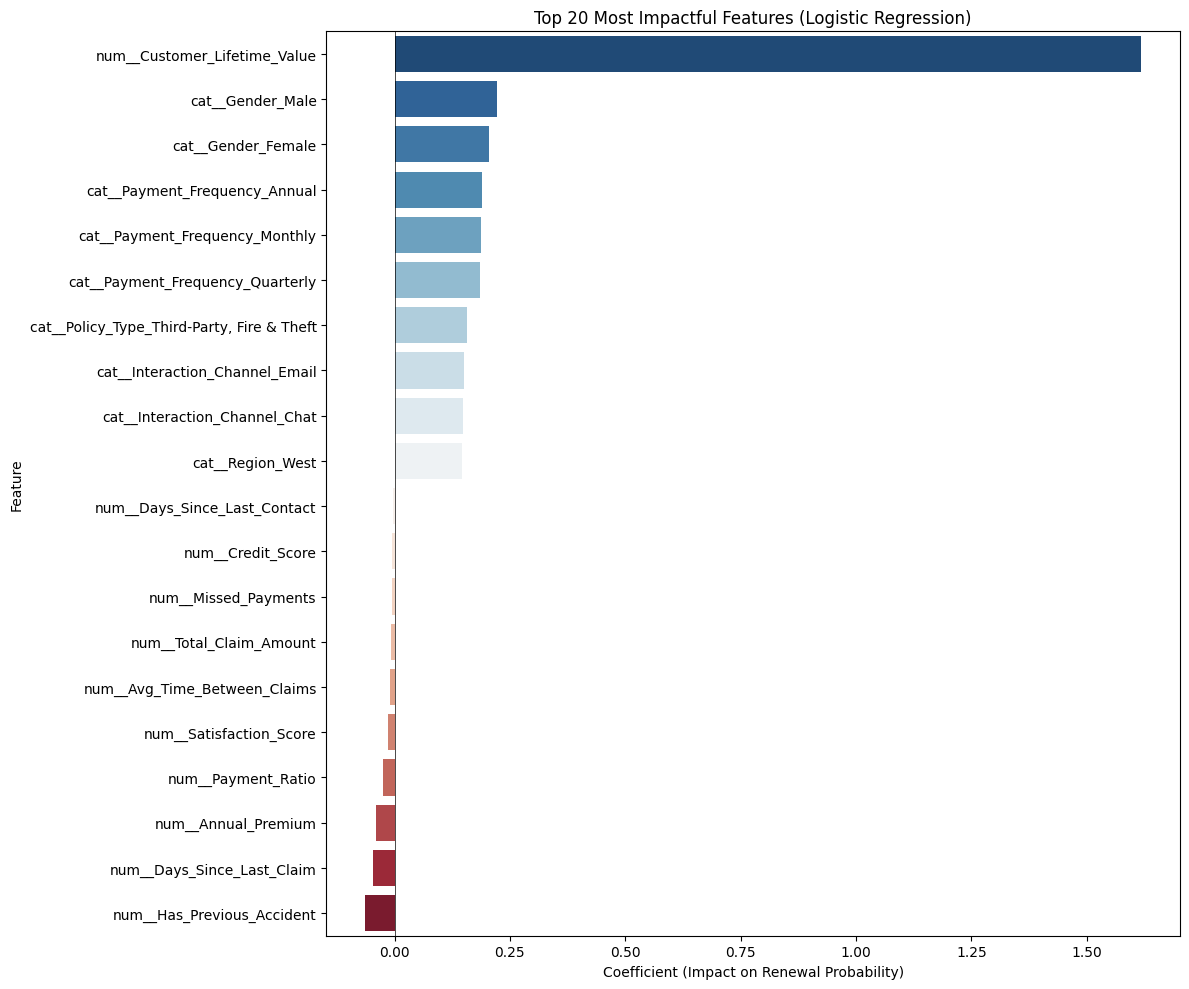

In [14]:
# Cell 14: Visualize Feature Importance

import seaborn as sns

# Get the top 10 positive and top 10 negative features
top_10_positive = coef_df.head(10)
top_10_negative = coef_df.tail(10)
top_bottom_10 = pd.concat([top_10_positive, top_10_negative])

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=top_bottom_10, 
    palette='RdBu_r' # Red for negative, Blue for positive
)
plt.title('Top 20 Most Impactful Features (Logistic Regression)')
plt.xlabel('Coefficient (Impact on Renewal Probability)')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

In [15]:
# Cell 15: Import, Create, and Train Random Forest

from sklearn.ensemble import RandomForestClassifier

# 1. Define the model
# n_jobs=-1 tells the model to use all available CPU cores for faster training.
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Create the full pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# 3. Train the model
print("Training the Random Forest model...")
rf_pipeline.fit(X_train, y_train)

print("Model training complete.")

Training the Random Forest model...
Model training complete.


In [16]:
# Cell 16: Evaluate Random Forest Performance

# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)

# Get prediction probabilities (for ROC-AUC score)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# 1. Calculate key metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_rf:.4f} (vs. Logistic Regression: {accuracy_lr:.4f})")
print(f"ROC-AUC Score: {roc_auc_rf:.4f} (vs. Logistic Regression: {roc_auc_lr:.4f})")

# 2. Print the detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Did Not Renew (0)', 'Renewed (1)']))

--- Random Forest Evaluation ---
Accuracy: 0.7596 (vs. Logistic Regression: 0.7655)
ROC-AUC Score: 0.7945 (vs. Logistic Regression: 0.8061)

Classification Report:
                   precision    recall  f1-score   support

Did Not Renew (0)       0.60      0.49      0.54      2895
      Renewed (1)       0.81      0.87      0.84      7105

         accuracy                           0.76     10000
        macro avg       0.71      0.68      0.69     10000
     weighted avg       0.75      0.76      0.75     10000



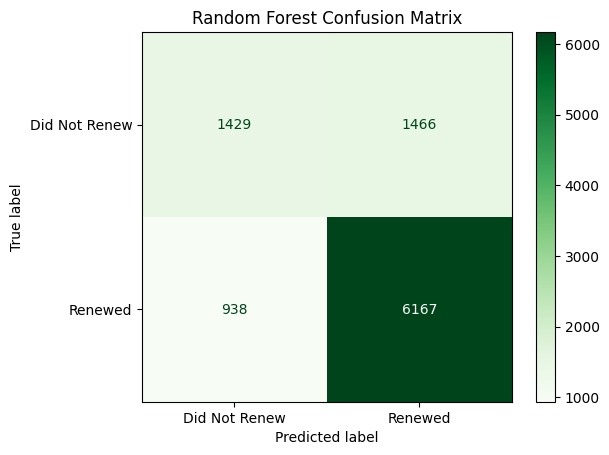

In [17]:
# Cell 17: Visualize Random Forest Confusion Matrix

# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf, 
    display_labels=['Did Not Renew', 'Renewed']
)

disp_rf.plot(cmap='Greens', values_format='d')
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.show()

In [18]:
# Cell 18: Install LightGBM (If Needed)

# Run this cell to install the lightgbm package
!pip install lightgbm

In [19]:
# Cell 19: Import, Create, and Train LightGBM

from lightgbm import LGBMClassifier

# 1. Define the model
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

# 2. Create the full pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

# 3. Train the model
# Note: LightGBM may show a [LightGBM] [Info]... message. This is normal.
print("Training the Gradient Boosting (LightGBM) model...")
lgbm_pipeline.fit(X_train, y_train)

print("Model training complete.")

Training the Gradient Boosting (LightGBM) model...
[LightGBM] [Info] Number of positive: 28421, number of negative: 11579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.710525 -> initscore=0.897935
[LightGBM] [Info] Start training from score 0.897935
Model training complete.


In [20]:
# Cell 20: Evaluate LightGBM Performance

# Make predictions on the test set
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Get prediction probabilities (for ROC-AUC score)
y_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

# 1. Calculate key metrics
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

print(f"--- Model Performance Comparison ---")
print("\n--- Gradient Boosting (LightGBM) ---")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"ROC-AUC Score: {roc_auc_lgbm:.4f}")

print("\n--- Random Forest (For Comparison) ---")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

print("\n--- Logistic Regression (For Comparison) ---")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC-AUC Score: {roc_auc_lr:.4f}")

# 2. Print the detailed Classification Report for LightGBM
print("\n--- LightGBM Classification Report ---")
print(classification_report(y_test, y_pred_lgbm, target_names=['Did Not Renew (0)', 'Renewed (1)']))

--- Model Performance Comparison ---

--- Gradient Boosting (LightGBM) ---
Accuracy: 0.7650
ROC-AUC Score: 0.8031

--- Random Forest (For Comparison) ---
Accuracy: 0.7596
ROC-AUC Score: 0.7945

--- Logistic Regression (For Comparison) ---
Accuracy: 0.7655
ROC-AUC Score: 0.8061

--- LightGBM Classification Report ---
                   precision    recall  f1-score   support

Did Not Renew (0)       0.61      0.51      0.56      2895
      Renewed (1)       0.81      0.87      0.84      7105

         accuracy                           0.77     10000
        macro avg       0.71      0.69      0.70     10000
     weighted avg       0.76      0.77      0.76     10000



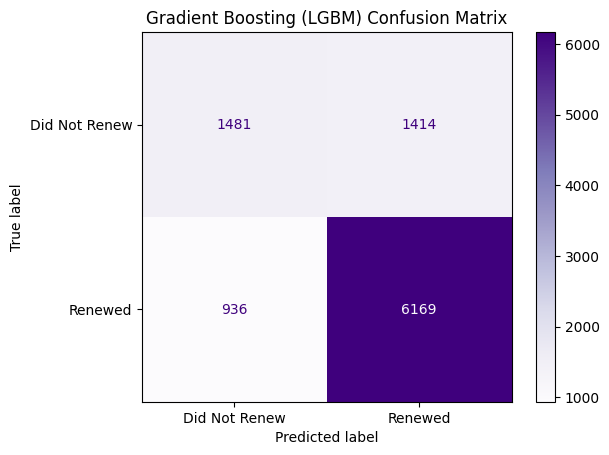

In [21]:
# Cell 21: Visualize LightGBM Confusion Matrix

# Generate the confusion matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Plot the confusion matrix
disp_lgbm = ConfusionMatrixDisplay(
    confusion_matrix=cm_lgbm, 
    display_labels=['Did Not Renew', 'Renewed']
)

disp_lgbm.plot(cmap='Purples', values_format='d')
plt.title('Gradient Boosting (LGBM) Confusion Matrix')
plt.grid(False)
plt.show()

In [22]:
# Cell 22: Analyze Feature Importance (LightGBM)

# Extract the fitted model and preprocessor
fitted_lgbm = lgbm_pipeline.named_steps['model']
fitted_preprocessor = lgbm_pipeline.named_steps['preprocessor']

# Get the feature names
feature_names = fitted_preprocessor.get_feature_names_out()

# Get the feature importances
importances = fitted_lgbm.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display the top 15 features
print("--- Top 15 Most Important Features (LightGBM) ---")
print(importance_df.head(15).to_string())

--- Top 15 Most Important Features (LightGBM) ---
                         Feature  Importance
12  num__Customer_Lifetime_Value         377
15  num__Days_Since_Last_Contact         294
9              num__Credit_Score         260
11       num__Satisfaction_Score         250
14  num__Days_Since_Last_Payment         244
0                       num__Age         216
8                num__Total_Paid         205
17            num__Payment_Ratio         179
5            num__Annual_Premium         165
6          num__On_Time_Payments         163
16    num__Days_Since_Last_Claim          98
3        num__Total_Claim_Amount          70
10          num__Support_Tickets          54
1       num__Policy_Tenure_Years          41
7           num__Missed_Payments          36


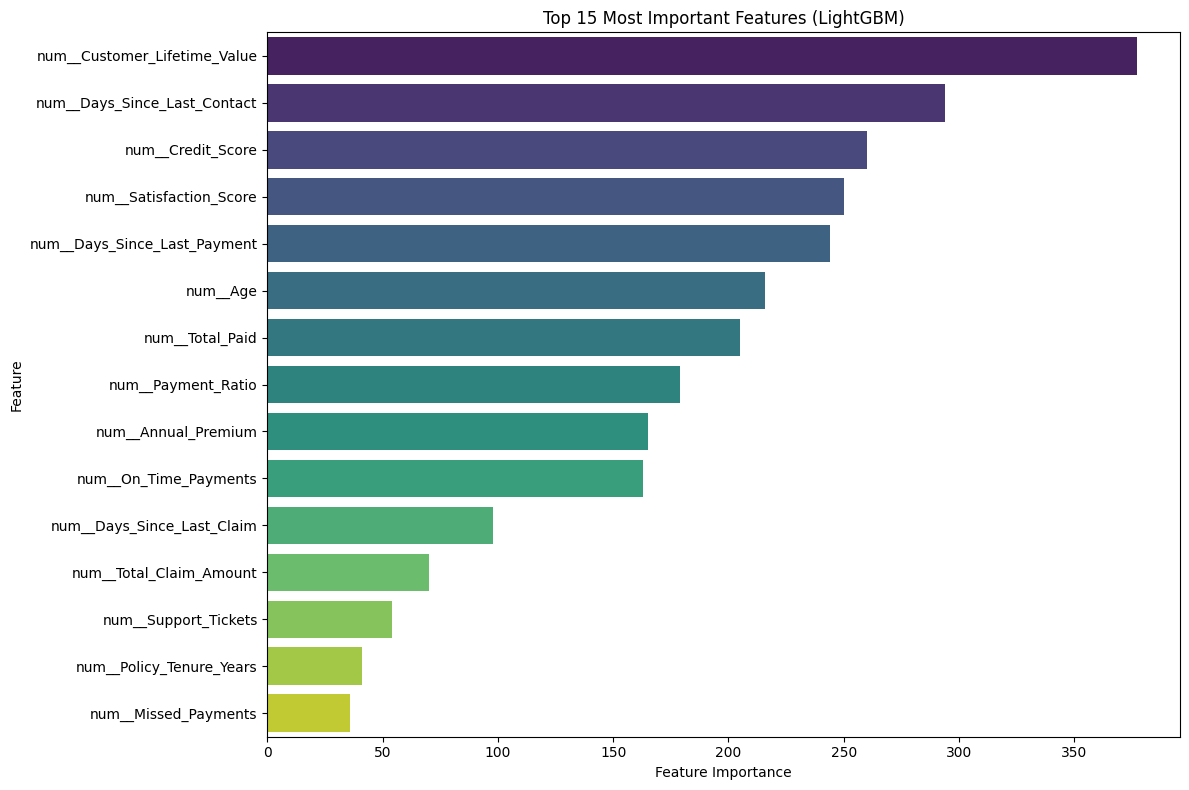

In [23]:
# Cell 23: Visualize Feature Importance

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Most Important Features (LightGBM)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [24]:
# Cell 24: Save the Best Model

import joblib

# Define the model we want to save (our best one)
best_model_pipeline = lr_pipeline
model_filename = 'renewal_model.joblib'

# Save the pipeline to a file
joblib.dump(best_model_pipeline, model_filename)

print(f"Model saved successfully as '{model_filename}'")

Model saved successfully as 'renewal_model.joblib'


In [25]:
# Cell 25: Load and Verify the Saved Model (Checkpoint Test)

# Load the model from the file
loaded_model = joblib.load(model_filename)

print(f"Model '{model_filename}' loaded successfully.")

# Make predictions using the *loaded* model
y_pred_loaded = loaded_model.predict(X_test)

# Check if the accuracy is identical
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)

print(f"Original model accuracy: {accuracy_lr:.4f}")
print(f"Loaded model accuracy:   {accuracy_loaded:.4f}")

if accuracy_loaded == accuracy_lr:
    print("\nCheckpoint successful! The loaded model works perfectly.")
else:
    print("\nCheckpoint failed. There's an issue with the saved model.")

Model 'renewal_model.joblib' loaded successfully.
Original model accuracy: 0.7655
Loaded model accuracy:   0.7655

Checkpoint successful! The loaded model works perfectly.


In [26]:
# Cell 26: Re-Train Logistic Regression (Balanced)
# 1. Define the balanced model
lr_model_balanced = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    class_weight='balanced' # This is the key change!
)

# 2. Create the full pipeline
lr_pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model_balanced)
])

# 3. Train the new model
print("Training the *Balanced* Logistic Regression model...")
lr_pipeline_balanced.fit(X_train, y_train)

print("Balanced model training complete.")


Training the *Balanced* Logistic Regression model...
Balanced model training complete.


In [27]:
# Cell 27: Evaluate the Balanced Model

# Make predictions on the test set
y_pred_lr_balanced = lr_pipeline_balanced.predict(X_test)

# Get prediction probabilities
y_prob_lr_balanced = lr_pipeline_balanced.predict_proba(X_test)[:, 1]

# 1. Calculate key metrics
accuracy_lr_balanced = accuracy_score(y_test, y_pred_lr_balanced)
roc_auc_lr_balanced = roc_auc_score(y_test, y_prob_lr_balanced)

print(f"--- Balanced Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_lr_balanced:.4f} (Original: {accuracy_lr:.4f})")
print(f"ROC-AUC Score: {roc_auc_lr_balanced:.4f} (Original: {roc_auc_lr:.4f})")
print("\nNote: A slight drop in overall accuracy is expected and acceptable,")
print("in exchange for much better recall on the minority class.")

# 2. Print the new Classification Report
print("\n--- Balanced Classification Report ---")
print(classification_report(y_test, y_pred_lr_balanced, target_names=['Did Not Renew (0)', 'Renewed (1)']))

print("\n--- Original Classification Report (for comparison) ---")
print(classification_report(y_test, y_pred_lr, target_names=['Did Not Renew (0)', 'Renewed (1)']))

--- Balanced Logistic Regression Evaluation ---
Accuracy: 0.7237 (Original: 0.7655)
ROC-AUC Score: 0.8061 (Original: 0.8061)

Note: A slight drop in overall accuracy is expected and acceptable,
in exchange for much better recall on the minority class.

--- Balanced Classification Report ---
                   precision    recall  f1-score   support

Did Not Renew (0)       0.52      0.77      0.62      2895
      Renewed (1)       0.88      0.71      0.78      7105

         accuracy                           0.72     10000
        macro avg       0.70      0.74      0.70     10000
     weighted avg       0.78      0.72      0.74     10000


--- Original Classification Report (for comparison) ---
                   precision    recall  f1-score   support

Did Not Renew (0)       0.62      0.50      0.55      2895
      Renewed (1)       0.81      0.87      0.84      7105

         accuracy                           0.77     10000
        macro avg       0.71      0.69      0.70     100

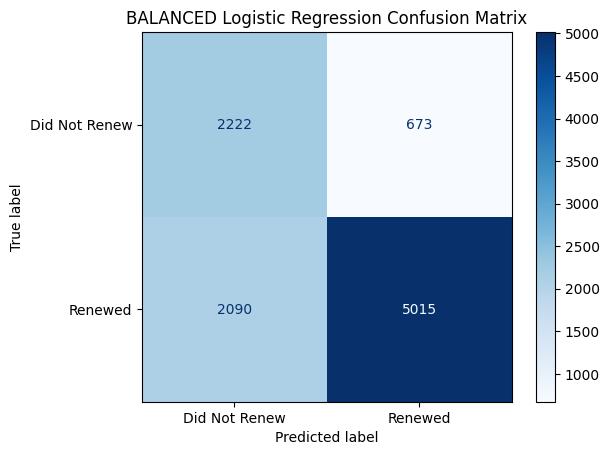

In [28]:
# Cell 28: Visualize the New Confusion Matrix

# Generate the confusion matrix
cm_lr_balanced = confusion_matrix(y_test, y_pred_lr_balanced)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr_balanced, 
    display_labels=['Did Not Renew', 'Renewed']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('BALANCED Logistic Regression Confusion Matrix')
plt.grid(False)
plt.show()

In [29]:
# Cell 29: Install imbalanced-learn

# Install the imbalanced-learn library for SMOTE
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [30]:
# Cell 30: Create the SMOTE + LightGBM Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# 1. Define the SMOTE strategy
# This will create synthetic samples of the minority class
smote = SMOTE(random_state=42)

# 2. Define the model
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

# 3. Create the special imblearn pipeline
# This pipeline will:
#    a) Preprocess the data (like before)
#    b) Apply SMOTE to the *training data only*
#    c) Train the LightGBM model on the *resampled* data
smote_lgbm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', lgbm_model)
])

print("SMOTE + LightGBM pipeline created successfully.")

SMOTE + LightGBM pipeline created successfully.


In [31]:
# Cell 31: Train the Advanced Pipeline

# Train the new advanced pipeline
print("Training the SMOTE + LightGBM model...")
print("This may take a moment as it's resampling the data...")

smote_lgbm_pipeline.fit(X_train, y_train)

print("Model training complete.")

Training the SMOTE + LightGBM model...
This may take a moment as it's resampling the data...
[LightGBM] [Info] Number of positive: 28421, number of negative: 28421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9239
[LightGBM] [Info] Number of data points in the train set: 56842, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model training complete.


In [32]:
# Cell 32: Evaluate the SMOTE + LightGBM Model

# Make predictions on the *original, unseen* test set
# The pipeline correctly does *not* apply SMOTE to X_test.
y_pred_smote_lgbm = smote_lgbm_pipeline.predict(X_test)

# Get prediction probabilities
y_prob_smote_lgbm = smote_lgbm_pipeline.predict_proba(X_test)[:, 1]

# 1. Calculate key metrics
accuracy_smote_lgbm = accuracy_score(y_test, y_pred_smote_lgbm)
roc_auc_smote_lgbm = roc_auc_score(y_test, y_prob_smote_lgbm)

print(f"--- SMOTE + LightGBM Evaluation ---")
print(f"Accuracy: {accuracy_smote_lgbm:.4f}")
print(f"ROC-AUC Score: {roc_auc_smote_lgbm:.4f}")

# 2. Print the new Classification Report
print("\n--- SMOTE + LightGBM Classification Report ---")
print(classification_report(y_test, y_pred_smote_lgbm, target_names=['Did Not Renew (0)', 'Renewed (1)']))

print("\n--- Balanced Logistic Regression Report (for comparison) ---")
print(classification_report(y_test, y_pred_lr_balanced, target_names=['Did Not Renew (0)', 'Renewed (1)']))

--- SMOTE + LightGBM Evaluation ---
Accuracy: 0.7639
ROC-AUC Score: 0.8027

--- SMOTE + LightGBM Classification Report ---
                   precision    recall  f1-score   support

Did Not Renew (0)       0.61      0.52      0.56      2895
      Renewed (1)       0.82      0.86      0.84      7105

         accuracy                           0.76     10000
        macro avg       0.71      0.69      0.70     10000
     weighted avg       0.76      0.76      0.76     10000


--- Balanced Logistic Regression Report (for comparison) ---
                   precision    recall  f1-score   support

Did Not Renew (0)       0.52      0.77      0.62      2895
      Renewed (1)       0.88      0.71      0.78      7105

         accuracy                           0.72     10000
        macro avg       0.70      0.74      0.70     10000
     weighted avg       0.78      0.72      0.74     10000



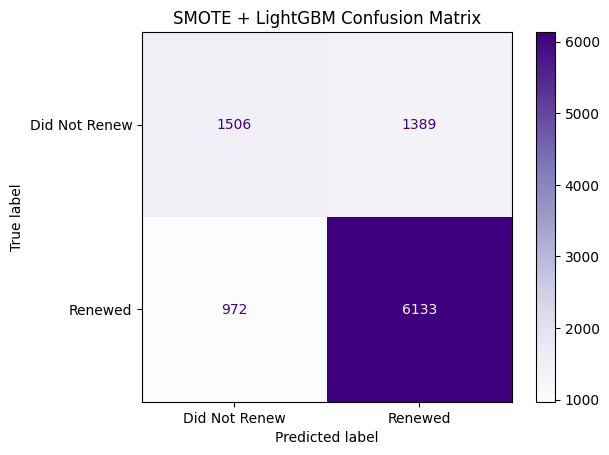

In [33]:
# Cell 33: Visualize the Final Confusion Matrix

# Generate the confusion matrix
cm_smote_lgbm = confusion_matrix(y_test, y_pred_smote_lgbm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_smote_lgbm, 
    display_labels=['Did Not Renew', 'Renewed']
)

disp.plot(cmap='Purples', values_format='d')
plt.title('SMOTE + LightGBM Confusion Matrix')
plt.grid(False)
plt.show()

In [34]:
# Cell 34: Save the Best Model (Balanced Logistic Regression)

import joblib

# Our best model is the Balanced Logistic Regression
best_model_pipeline = lr_pipeline_balanced
model_filename = 'renewal_model_v2_balanced.joblib'

# Save the pipeline to a file
joblib.dump(best_model_pipeline, model_filename)

print(f"Model saved successfully as '{model_filename}'")

# You can load this file later using:
# loaded_model = joblib.load('renewal_model_v2_balanced.joblib')

Model saved successfully as 'renewal_model_v2_balanced.joblib'
